# Степ-проєкт з модулю Python "БАЗА ДАНИХ IKEA"

# група ВІ-6 

# Кузьменко Сергій


## Завдання проєкту:

### 1. Скачайте набір даних IKEA.
### 2. Виконайте дослідження для набору даних, включаючи описову статистику та візуалізації. Опишіть результати. 
### 3. На основі EDA і вашого здорового глузду виберіть дві гіпотези, які ви хочете перевірити/проаналізувати. Для кожноЇ гіпотези перерахуйте нульову гіпотезу та інші можливі альтернативні гіпотези, розробте тести, щоб розрізняти їх, та виконайте їх. Опишіть результати.
### 4. Навчіть модель передбачати ціну на меблі. 
###      - вкажіть, які стовпці не слід включати до моделі та чому;
###      - створіть конвеєр перехресної перевірки для навчання та оцінки моделі, включаючи (при необхідності) такі кроки як пропущених значень та нормалізація;
###      - запропонуйте методи підвищення продуктивності моделі; 
###      - опишіть результати.

# 1. Підготовча частина

### 1.1. Імпорт бібліотек та процедур

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

### 1.2. Зчитування початкових даних

In [229]:
data_ikea = pd.read_csv("D:\\ikea.csv")
data_ikea.head()

Unnamed: 0   item_id                   name       category   price  \
0           0  90420332               FREKVENS  Bar furniture   265.0   
1           1    368814              NORDVIKEN  Bar furniture   995.0   
2           2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0   
3           3  80155205                   STIG  Bar furniture    69.0   
4           4  30180504                NORBERG  Bar furniture   225.0   

      old_price  sellable_online  \
0  No old price             True   
1  No old price            False   
2  No old price            False   
3  No old price             True   
4  No old price             True   

                                                link other_colors  \
0  https://www.ikea.com/sa/en/p/frekvens-bar-tabl...           No   
1  https://www.ikea.com/sa/en/p/nordviken-bar-tab...           No   
2  https://www.ikea.com/sa/en/p/nordviken-nordvik...           No   
3  https://www.ikea.com/sa/en/p/stig-bar-stool-wi...          Yes   
4  https://www.ikea.com/sa/en/p/norberg-wall-moun...           No   

                                   short_description              designer  \
0           Bar table, in/outdoor,          51x51 cm  Nicholai Wiig Hansen   
1                      Bar table,          140x80 cm     Francis Cayouette   
2                         Bar table and 4 bar stools     Francis Cayouette   
3            Bar stool with backrest,          74 cm         Henrik Preutz   
4          Wall-mounted drop-leaf table,         ...        Marcus Arvonen   

   depth  height  width  
0    NaN    99.0   51.0  
1    NaN   105.0   80.0  
2    NaN     NaN    NaN  
3   50.0   100.0   60.0  
4   60.0    43.0   74.0

### 1.3. Перевірка наявності в даних NaN

In [230]:
print('\n Check NaN in DataFrame: \n', data_ikea.isna().sum())


 Check NaN in DataFrame: 
 Unnamed: 0              0
item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64


Відсутність даних спостерігається лише у трьох останніх колонках, де представлені геометричні розміри товару - 
глубина, висота та довжина.
З огляду на те, що ці дані є чисельними - проведемо заміну відсутних даних на нуль.

In [231]:
data_ikea = data_ikea.fillna(0)

print('\n Check NaN in DataFrame: \n', data_ikea.isna().sum())


 Check NaN in DataFrame: 
 Unnamed: 0           0
item_id              0
name                 0
category             0
price                0
old_price            0
sellable_online      0
link                 0
other_colors         0
short_description    0
designer             0
depth                0
height               0
width                0
dtype: int64


### 1.4. Обробка початкових даних та часткове перетворення датасету

**Перша гіпотеза**, яка буде розглядатися пізніше в цій роботі - це перевірка кореляції між об'ємом товару та його ціною. Тому дуже важливим є відтворення відсутніх даних щодо геометричних розмірів товарів.

Відсутність геометричних розмірів частково можно відновити завдяки даним в колонці "short_description", в якій, більшою частитною, прописані ці геометричні розміри.
Наприклад, для 80 строки: "Bed frame with 10 doors,          143x244x223 cm"

В цій строці можно виділити: розмірність даних, тобто сантиметри, 
                             довжину, глубину та висоту товару, які перелічені через символ "х"

Таким чином, стає можливим отримати дані яких не вистачає, та додатково перевірити якість даних по розмірах товарів, які вже присутні в початкових даних.

В цьому ж прикладі для 80 строки: "Bed frame with 10 doors,          143x244x223 cm", дані які вже записані в початковому файлі мають наступні значення: depth (глубина) - 40,  height (висота) - 43, width (довжина) - 143. Тобто з трьох розмірів правильним є тільки один - довжина.

Таким чином, стає потрібним провести аналіз всіх записів в колонці "short_description", отримати, за наявністю, геометричні розміри виробу та порівняти їх із даними, котрі вже є в датафреймі. 

У тих випадках, коли отримані дані з колонки "short_description" більші, ніж вже існуючі в колонках "depth", "height" і "width" геометричні розміри товарів з колонки "short_description" будуть записані в колонках "depth", "height" і "width".

Деякі особливості при отриманні даних щодо геометричних розмірів з колонки "short_description":
- розмір виду "320 mm" показує розмірність даних в мм; при отриманні такого типу даних будемо отримане число ділити на 10.
- розмір виду: "175x30-104x179 cm" показує можливість варіювання висоти виробу від 30 см до 104 см; в даному випадку залишаємо 
  меньший розмір - "175x30x179 cm";
- розмір виду "100/155 cm" будемо сприймати як "100х155 cm"
- розмір виду "74/106/138x80 cm" будемо сприймати як "74-106/138x80 cm" і залишаємо "74х138x80 cm"

**Друга гіпотеза**, яка буде розглядатися пізніше в цій роботі - це перевірка кореляції між кількістю дизайнерів та ціною товару. 

Дані, які представлені у колонці "designer" мають наступний вигляд: 
"Ehlén Johansson", "K Hagberg/M Hagberg" чи "S Lanneskog/J Marnell/IKEA of Sweden"

Таким чином, кількість дизайнерів буде зводитися к підрахунку кількості символів "/" та збільшення цієї кількості на 1

Для спрощення наступної обробки даних буде додано наступні колонки:
- id_category (int) - номер категорії товару, щоб відійти від текстової інформації
- volume (float) - об'єм виробу (площа для двомірних розмірів або довжина для одномірних розмірів)
- corner (int) - кутовий тип виробу чи прямолінійний (1 - кутовий, 0 - прямолінійний) 
- 3d (int) - тип товару за формою (3 - об'ємний, має три геометричні розміри, 2 - плоский, має два геометричні розміри, 1 - лінійний, має один геометричний розмір, 0 - геометричні розміри відсутні)
- number_designer (int) - кількість дизайнерів товару

In [232]:
# Пошук та виділення масива даних з розмірами товарів в сантіметрах (в стовбці "short_description")
def find_dimension_cm(text):
    text1 = ''
    i = text.find(' cm')
    if i != -1:
        for j in reversed(range(i)):
            if text[j] == ' ':
                text1 = text[(j + 1):i]
                break
    return text1

# Пошук та виділення масива даних з розмірами товарів в міліметрах (в стовбці "short_description")
def find_dimension_mm(text):
    text1 = ''
    i = text.find(' mm')
    if i != -1:
        for j in reversed(range(i)):
            if text[j] == ' ':
                text1 = text[(j + 1):i]
                break
    return text1

# Пошук та видалення в розмірах товарів елемента дефіс ("-") с заміню на "х"
def find_dash(text):
    i = text.find('-')
    text1 = text
    if i != -1:
        j = text.find('x')
        if i < 5:
            if j == -1:
                text1 = text[:i]
            else:
                text1 = text[:i] + 'x' + text[(j + 1):]
        elif i > (len(text) - 5):
            text1 = text[:i]
        else:
            j = text.rfind('x')
            text1 = text[:i] + text[j:]
    return text1

#  Пошук та видалення в розмірах товарів елемента слеш ("/") с заміню на "х"
def find_slash(text, text_first):
    num_slash = text.count('/')
    num_x = text.count('x')
    text1 = text
    if num_slash == 2 and num_x == 1:
        i1 = text.find('/')
        i2 = text.rfind('/')
        if i1 != -1 and i2 != -1 and i1 != i2:
            i_table = text_first.find('table')
            if i_table != -1:
                text1 = text[:i1] + text[i2:]
            i_wardrobe = text_first.find('wardrobe')
            if i_wardrobe != -1:
                text1 = text[(i1 + 1):]
    if num_slash == 1 and num_x == 2:
        i1 = text.find('/')
        i2 = text.rfind('x')
        text1 = text[:i1] + text[i2:]
    text1 = text1.replace('/', 'x')
    return text1

# Отримання списку із новими розмірами товарів
def get_dimension(text):
    new_dimension = []
    if text == '':
        new_dimension = [0, 0, 0]
    else:
        if text.count('x') == 0:
            c = float(text)
            new_dimension = [0, 0, c]
        elif text.count('x') == 1:
            i = text.find('x')
            c = float(text[:i])
            b = float(text[(i + 1):])
            new_dimension = [0, b, c]
        else:
            i1 = text.find('x')
            i2 = text.rfind('x')
            c = float(text[:i1])
            a = float(text[(i1 + 1):i2])
            b = float(text[(i2 + 1):])
            new_dimension = [a, b, c]
    return new_dimension

# Запис у початковий датафрейм нових розмірів товарів (які були отримані раніше у "def get_dimension") 
# у тому випадку, коли вони більше за початкові
def new_dimension(df):
    for index_df in df.index:
        dim_first = df.loc[index_df, 'short_description']
        dim_cm = find_dimension_cm(dim_first)
        dim_mm = find_dimension_mm(dim_first)

        if dim_mm != '' or dim_cm != '':
            if dim_mm != '':
                dim = dim_mm
            else:
                dim = dim_cm
            dim1 = find_dash(dim)
            dim2 = find_slash(dim1, dim_first)
            new_dim = get_dimension(dim2)
            if dim_mm != '':
                new_dim[0] = new_dim[0] / 10
                new_dim[1] = new_dim[1] / 10
                new_dim[2] = new_dim[2] / 10
        else:
            new_dim = [0, 0, 0]

        if new_dim[0] > df.loc[index_df, 'depth']:
            df.loc[index_df, 'depth'] = new_dim[0]
        if new_dim[1] > df.loc[index_df, 'height']:
            df.loc[index_df, 'height'] = new_dim[1]
        if new_dim[2] > df.loc[index_df, 'width']:
            df.loc[index_df, 'width'] = new_dim[2]
    return df

# Вставка нових колонок для можливості поглибленого аналізу даних
def add_columns(df):
    df.insert(4, 'id_category', 0) # Номер категорії товарів
    df.insert(15, 'volume', 0.0) # Об'єм (площа або лінійний розмір) товарів
    df.insert(16, 'corner', 0) # Чи кутовий товар (1 - так, 0 - лінійний)
    df.insert(17, '3d', 0) # Скільки розмірів товарів є (3 - ширина, глубина, висота; 2 - ширина, висота; 1 - довжина; 0 -номає)
    df.insert(18, 'number_designer',1) # Кількість дизайнерів, що створювали товар
    return df

# Визначення об'єму (площі чи лінійного розміру) товара
def add_volume(df):
    new_dim = [0, 0, 0]
    for index_df in df.index:
        new_dim[0] = df.loc[index_df, 'depth']
        new_dim[1] = df.loc[index_df, 'height']
        new_dim[2] = df.loc[index_df, 'width']
        volume = 0
        num_3d = 0
        for i in range(3):
            if new_dim[i] != 0:
                num_3d += 1
                if volume == 0:
                    volume = new_dim[i]
                else:
                    volume = volume * new_dim[i]
        if df.loc[index_df, 'corner'] == 1: 
            volume = volume / 2 # Для трикутників площа обчислюється як а*в/2
        df.loc[index_df, 'volume'] = volume
        df.loc[index_df, '3d'] = num_3d
    return df

# Визначення кількості дизайнерів, форми товара, кількості місць для сидіння, кількості елементів в одному товарі
def add_other(df):
    for index_df in df.index:
        # Визначення кількості дизайнерів
        text = df.loc[index_df, 'designer']
        i = text.count('/')
        if i>0:
            df.loc[index_df, 'number_designer'] = int(i)+1
        text = df.loc[index_df, 'short_description']
        # Пошук та додавання даних щодо форми товару(лінійний -0, кутовий - 1)
        i1 = text.find('Corner')
        i2 = text.find('corner')
        if i1!=-1 or i2!=-1:
            df.loc[index_df, 'corner']=1
    return df

# Визначення переліку назв категорій товарів та запис до початкового датафрейму їх порідкові номери
def add_id_category(df):
    name_category = df['category'].unique().tolist()
    for index_df in df.index:
        for name in name_category:
            if df.loc[index_df, 'category'] == name:
                df.loc[index_df, 'id_category'] = name_category.index(name)+1
    return df

# Додання нових стовпчиків для спрощення аналізу даних
data_ikea = add_columns(data_ikea)

# Отримання додаткових даних щодо розмірів товарів із колонки "short_description"
data_ikea = new_dimension(data_ikea)

# Розрахунок об'єму (площі або лінійного розміру) товару та додавання цього показника до датафруйму
data_ikea = add_volume(data_ikea)

# Вибір додаткових даних з колонок "short_description" "designer", таких як:
#  - форма товару (кутова чи лінійна)
#  - кількість дизайнерів
data_ikea = add_other(data_ikea)

# Додання номера категорії товару в стовбець "id_category"
data_ikea = add_id_category(data_ikea)

data_ikea = data_ikea.fillna(0)
data_ikea.info()
data_ikea.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   id_category        3694 non-null   int64  
 5   price              3694 non-null   float64
 6   old_price          3694 non-null   object 
 7   sellable_online    3694 non-null   bool   
 8   link               3694 non-null   object 
 9   other_colors       3694 non-null   object 
 10  short_description  3694 non-null   object 
 11  designer           3694 non-null   object 
 12  depth              3694 non-null   float64
 13  height             3694 non-null   float64
 14  width              3694 non-null   float64
 15  volume             3694 non-null   float64
 16  corner             3694 

Unnamed: 0   item_id                   name       category  id_category  \
0           0  90420332               FREKVENS  Bar furniture            1   
1           1    368814              NORDVIKEN  Bar furniture            1   
2           2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture            1   
3           3  80155205                   STIG  Bar furniture            1   
4           4  30180504                NORBERG  Bar furniture            1   

    price     old_price  sellable_online  \
0   265.0  No old price             True   
1   995.0  No old price            False   
2  2095.0  No old price            False   
3    69.0  No old price             True   
4   225.0  No old price             True   

                                                link other_colors  \
0  https://www.ikea.com/sa/en/p/frekvens-bar-tabl...           No   
1  https://www.ikea.com/sa/en/p/nordviken-bar-tab...           No   
2  https://www.ikea.com/sa/en/p/nordviken-nordvik...           No   
3  https://www.ikea.com/sa/en/p/stig-bar-stool-wi...          Yes   
4  https://www.ikea.com/sa/en/p/norberg-wall-moun...           No   

                                   short_description              designer  \
0           Bar table, in/outdoor,          51x51 cm  Nicholai Wiig Hansen   
1                      Bar table,          140x80 cm     Francis Cayouette   
2                         Bar table and 4 bar stools     Francis Cayouette   
3            Bar stool with backrest,          74 cm         Henrik Preutz   
4          Wall-mounted drop-leaf table,         ...        Marcus Arvonen   

   depth  height  width    volume  corner  3d  number_designer  
0    0.0    99.0   51.0    5049.0       0   2                1  
1    0.0   105.0  140.0   14700.0       0   2                1  
2    0.0     0.0    0.0       0.0       0   0                1  
3   50.0   100.0   74.0  370000.0       0   3                1  
4   60.0    60.0   74.0  266400.0       0   3                1

# 2. Аналіз даних. Перевірка гіпотез з використанням критерія Пірсона

## 2.1. Перша гіпотеза

**Перша гіпотеза step-проєкту** - визначення того, чи є кореляція між об'ємом (площею чи лінійним розміром) товара та його ціною.

**Для перевірки першої гіпотези разглядалися: нульова гіпотеза і альтернативна гіпотеза.**

**Нульова гіпотеза** - є кореляція між об'ємом (площею чи лінійним розміром) та ціною всіх товарів з початкових даних. 
При цьому коефіцієнт кореляції Пірсона складає більше 0,7

**Альтернативна гіпотеза** - є кореляція між об'ємом (площею чи лінійним розміром) та ціною груп товарів із особистими властивостями
(наприклад, кутова шафа чи лінійна; скільки елементів включає один товар) з початкових даних. 
При цьому коефіцієнт кореляції Пірсона складає більше 0,7
Перевірку альтернативної гіпотези проведемо для категорій 'Wardrobes'



### 2.1.1. Виведення точкової діаграми залежності об'єму (площі чи лінійного розміру) всіх товарів від їх ціни
Товари, які не мають розмірів - видалені з датафрейму

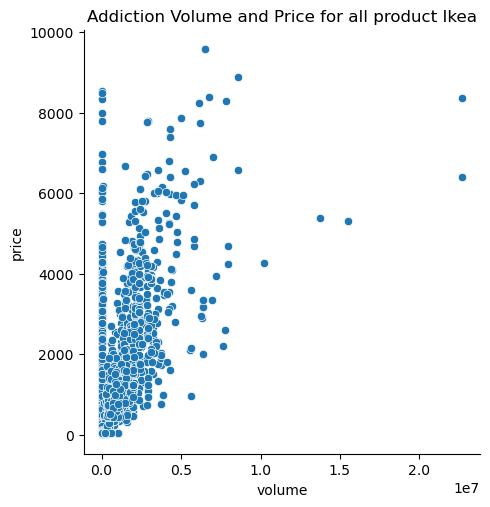

In [233]:
data_vp = data_ikea[['category','volume', 'corner', 'price']] #vp - volume and price
data_vp = data_vp.loc[data_vp['volume'] > 0]
sns.relplot(data=data_vp, x='volume', y='price').set (title='Addiction Volume and Price for all product Ikea') 
plt.show()

Як можна бачити з графику, розподіл значень має великий розкид і навряд чи нульова гіпотеза підтвердиться

### 2.1.2. Перевірка нульової гіпотези по критерію Пірсона

In [234]:
print('Calculating Pearson`s criteria for addiction Volume and Price for all product')
print()
print(pearsonr(data_vp['volume'], data_vp['price']))
print(pearsonr(data_vp['volume'], data_vp['price']).confidence_interval())

Calculating Pearson`s criteria for addiction Volume and Price for all product

PearsonRResult(statistic=0.5818314438537096, pvalue=1.946571591742e-311)
ConfidenceInterval(low=0.5593072145899254, high=0.6034971758598027)


**Нульова гіпотеза не підтвердилася.** 
Критерій Пірсона склав 0,58 (менше ніж 0,7 за умови нульової гіпотези) із довірчим інтервалом значень від 0,559 до 0,603.



### 2.1.3. Виведення точкових діаграм залежності об'єму (площі чи лінійного розміру) товара (по категоріям) від його ціни

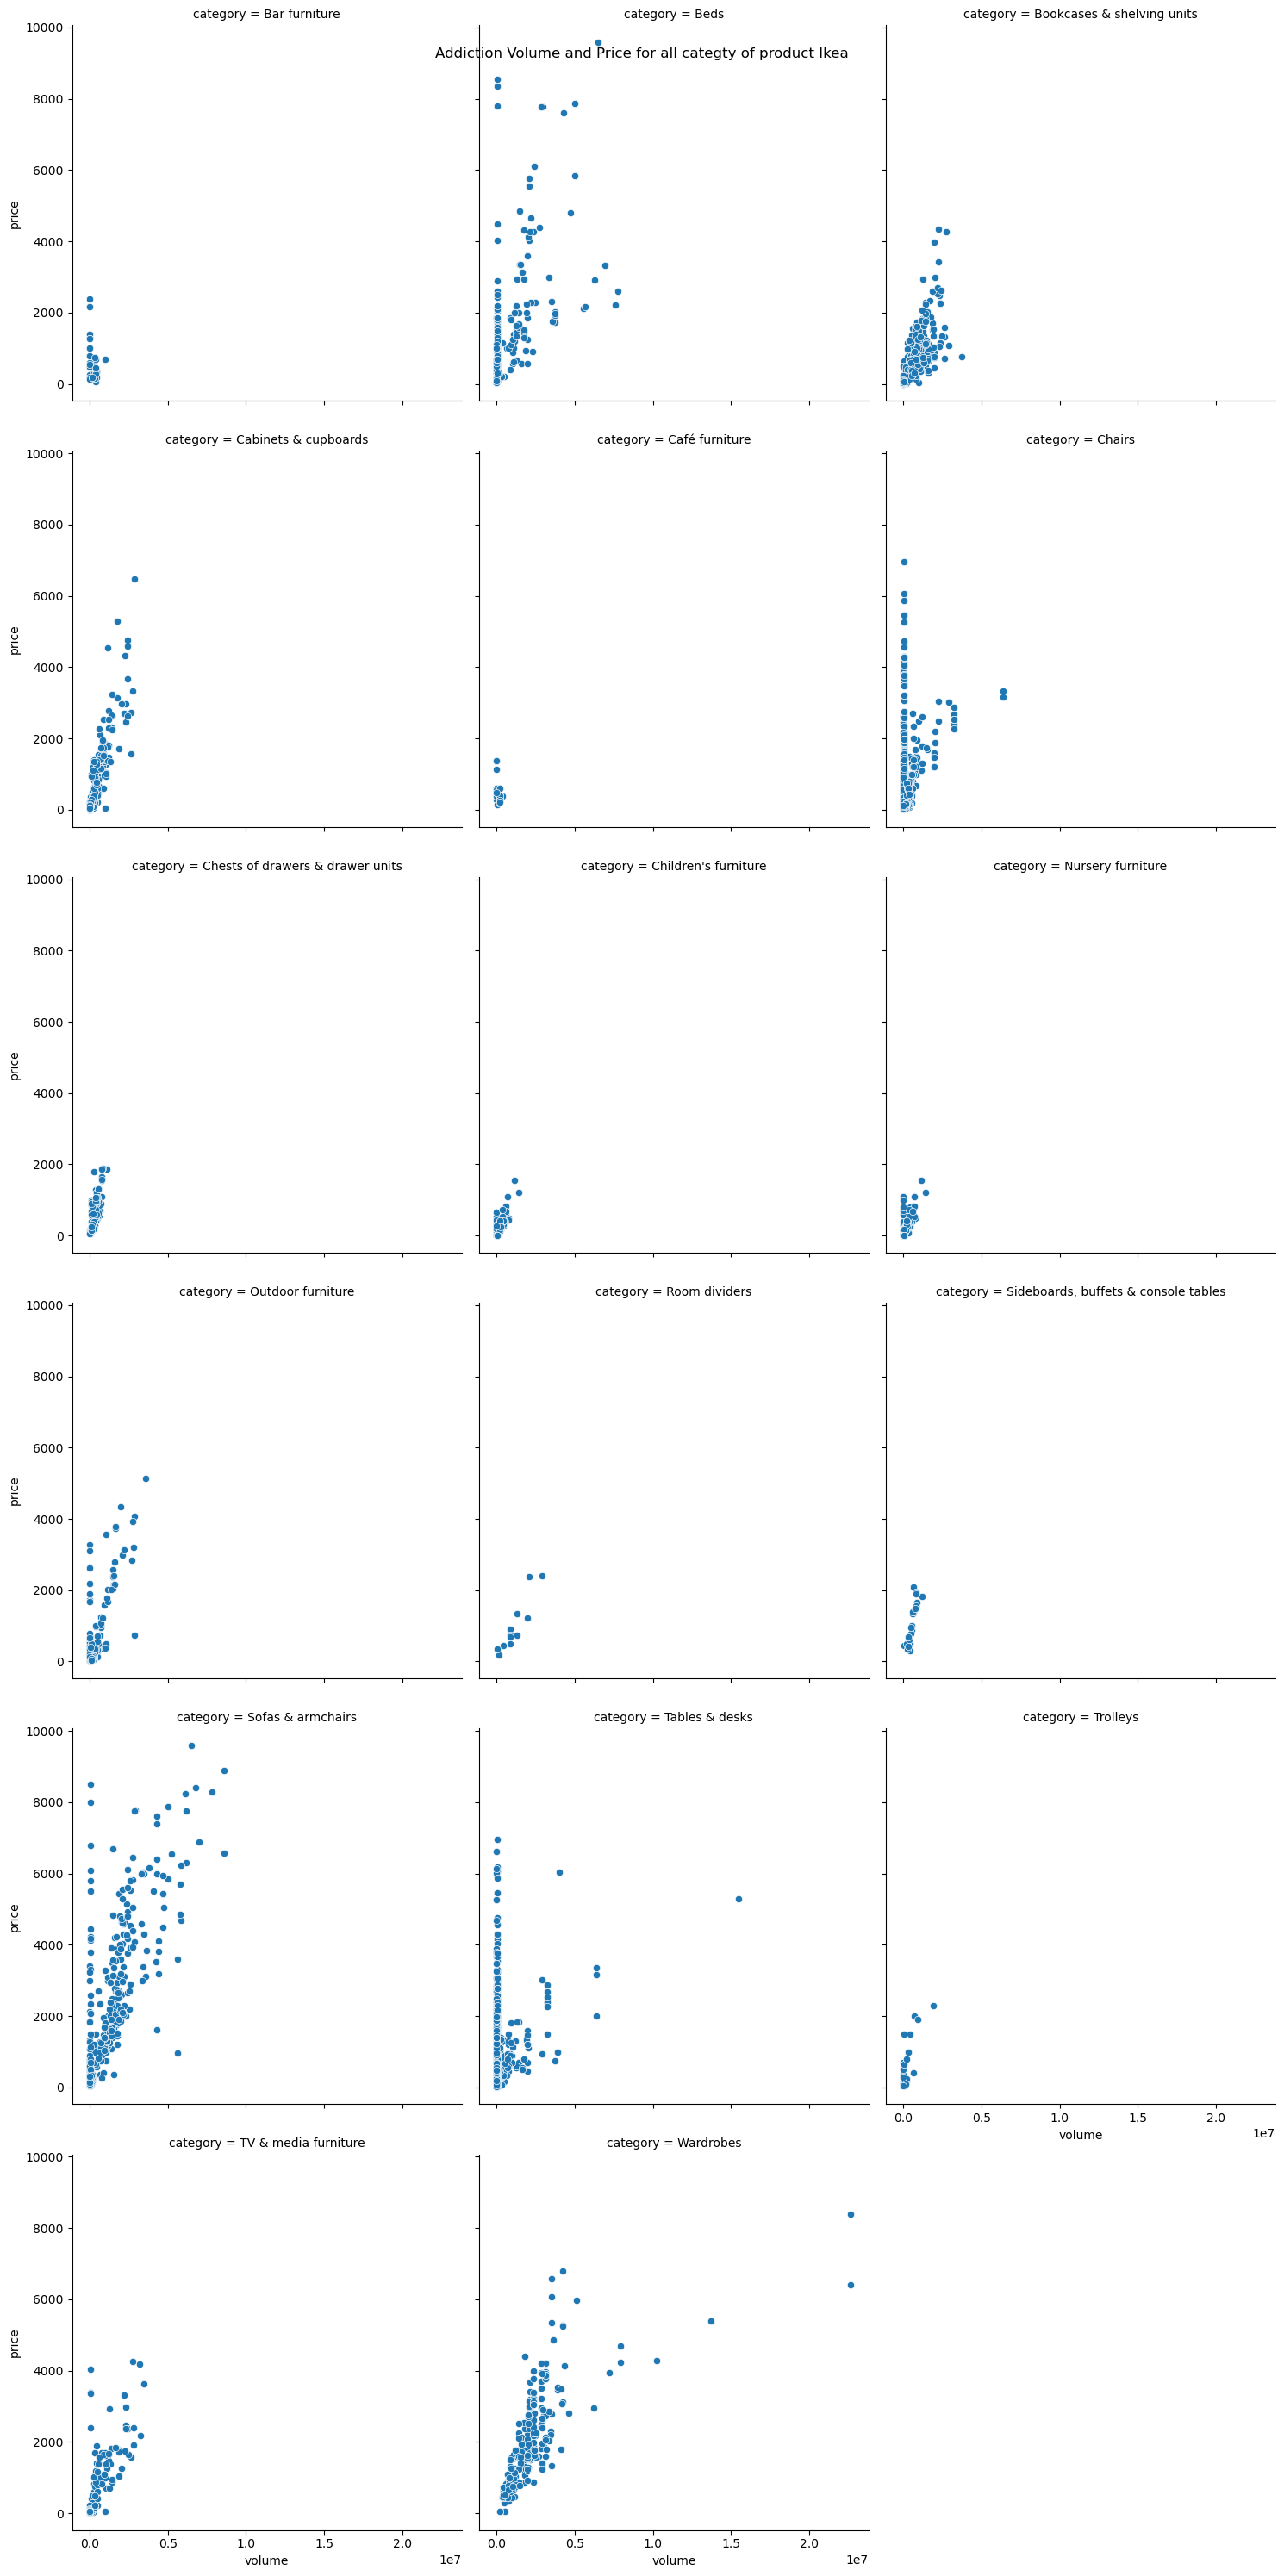

In [235]:
sns.relplot(data=data_vp, x='volume', y='price', col='category', col_wrap=3).fig.suptitle('Addiction Volume and Price for all categty of product Ikea', va='top')
plt.show()

Як можна побачити із графічних залежностей, розбиття по категоріях показує більш привабливий зміст з точки зору знаходження
кореляцій. Є характерні масиви точок, які мають спільні риси у своїх формах.
Дуже велика вирогидність підтвердження альтернативної гіпотези

### 2.1.4. Перший етап перевірки альтернативної гіпотези по критерію Пірсона. Категорія товарів - Wardrobes

In [236]:
data_vp_vardrobes = data_vp.loc[data_vp['category'] =='Wardrobes']
print('Calculating Pearson`s criteria for addiction Volume and Price for Wardrobes\n')
print(pearsonr(data_vp_vardrobes['volume'], data_vp_vardrobes['price']))
print(pearsonr(data_vp_vardrobes['volume'], data_vp_vardrobes['price']).confidence_interval())

Calculating Pearson`s criteria for addiction Volume and Price for Wardrobes

PearsonRResult(statistic=0.6824822744487076, pvalue=1.0562147779166972e-33)
ConfidenceInterval(low=0.6077491448074434, high=0.7452332117531243)


**Альтернативна гіпотеза за критерієм Пірсона не підтвердилася.** 
Критерій Пірсона склав 0,68 (менше ніж 0,7 за умови альтернативної гіпотези) із довірчим інтервалом значень від 0,608 до 0,745
Хоча верхня межа довірчого інтервалу вже потрапила до заявленого значення 0,7

### 2.1.5. Другий етап перевірки альтернативної гіпотези по критерію Пірсона. Категорія товарів - Wardrobes, форма товару - лінийна

In [237]:
data_vp_vardrobes_linear = data_vp.loc[((data_vp['category'] =='Wardrobes')&(data_vp['corner'] ==0))]
print('Calculating Pearson`s criteria for addiction Volume and Price for Wardrobes (lenear)\n')
print(pearsonr(data_vp_vardrobes_linear['volume'], data_vp_vardrobes_linear['price']))
print(pearsonr(data_vp_vardrobes_linear['volume'], data_vp_vardrobes_linear['price']).confidence_interval())

Calculating Pearson`s criteria for addiction Volume and Price for Wardrobes (lenear)

PearsonRResult(statistic=0.7257664890733551, pvalue=6.34068556182571e-38)
ConfidenceInterval(low=0.6572074378457661, high=0.7824139533597575)


**Альтернативна гіпотеза за критерієм Пірсона підтвердилася.** 
Критерій Пірсона склав 0,72 (більше ніж 0,7 за умови альтернативної гіпотези) із довірчим інтервалом значень від 0,657 до 0,782

### 2.1.6. Третій етап перевірки альтернативної гіпотези по критерію Пірсона. Категорія товарів - Wardrobes, форма товару - кутова

In [238]:
data_vp_vardrobes_corner = data_vp.loc[((data_vp['category'] =='Wardrobes')&(data_vp['corner'] ==1))]
print('Calculating Pearson`s criteria for addiction Volume and Price for Wardrobes (corner)\n')
print(pearsonr(data_vp_vardrobes_corner['volume'], data_vp_vardrobes_corner['price']))
print(pearsonr(data_vp_vardrobes_corner['volume'], data_vp_vardrobes_corner['price']).confidence_interval())

Calculating Pearson`s criteria for addiction Volume and Price for Wardrobes (corner)

PearsonRResult(statistic=0.9382563014326062, pvalue=6.367799005218369e-06)
ConfidenceInterval(low=0.7894441638900322, high=0.9828992800020951)


**Альтернативна гіпотеза за критеріїм Пірсона підтвердилася.** 
Критерій Пірсона склав 0,94 (більше ніж 0,7 за умови альтернативної гіпотези) із довірчим інтервалом значень від 0,7898 до 0,983
Самий кращій варант альтернативної гіпотези.

### 2.1.7. Виведення точкової діаграми із рівнянням лінійної регресії залежності об'єму товара від його ціни за категорією Wardrobes в залежності від його форми 

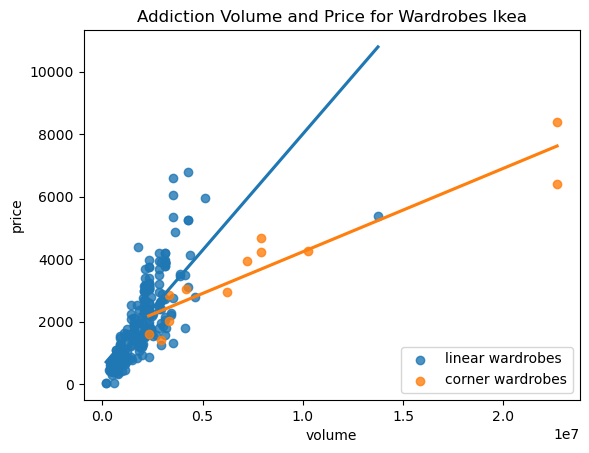

In [239]:
sns.regplot(data=data_vp_vardrobes_linear, x='volume', y='price', ci=None, label='linear wardrobes').set(
    title='Addiction Volume and Price for Wardrobes Ikea')
sns.regplot(data=data_vp_vardrobes_corner, x='volume', y='price', ci=None, label='corner wardrobes')
plt.legend(loc='lower right')
plt.show()

Масив представлених точок на графіку показує наявність лінійної кореліяції між об'ємом товару та його ціною.
Розташування точок має витягнуту форму, близьку до лінії.
Адекватність альтенативної гіпотези підтвердилося при попередніх розрахунках критерія Пірсона

## 2.2. Друга гіпотеза

**Друга гіпотеза step-проєкту** - визначення того, чи є кореляція між ціною товара та кількістю дизайнерів.

**Для перевірки другої гіпотези разглядалися: нульова гіпотеза і альтернативна гіпотеза.**

**Нульова гіпотеза** - є кореляція між кількістю дизайнерів та ціною всіх товарів з початкових даних. 
При цьому коефіцієнт кореляції Пірсона складає більше 0,7

**Альтернативна гіпотеза** - є кореляція між кількістю дизайнерів та ціною груп товарів із особистими властивостями
(наприклад, кутова шафа чи лінійна; скільки елементів включає один товар) з початкових даних. 
При цьому коефіцієнт кореляції Пірсона складає більше 0,7. Перевірку альтернативної гіпотези проведемо для категорій 'Wardrobes'

### 2.2.1. Виведення точкової діаграми залежності ціни товара від кількості дизайнерів

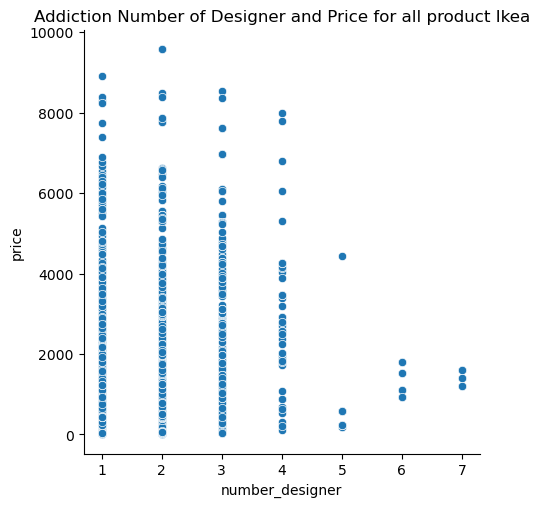

In [240]:
data_dp = data_ikea[['category','corner','number_designer', 'price']] #dp - designer and price
sns.relplot(data=data_dp, x='number_designer', y='price').set (title='Addiction Number of Designer and Price for all product Ikea') 
plt.show()

Представлена точкова діаграма показує дуже велике розпорошення даних і, скоріш за все - нульва гіпотеза не підтвердиться

### 2.2.2. Перевірка нульової гіпотези по критерію Пірсона

In [241]:
print('Calculating Pearson`s criteria for addiction Number of Designer and Price for all product Ikea\n')
print(pearsonr(data_dp['number_designer'], data_dp['price']))
print(pearsonr(data_dp['number_designer'], data_dp['price']).confidence_interval())

Calculating Pearson`s criteria for addiction Number of Designer and Price for all product Ikea

PearsonRResult(statistic=0.3262296366448839, pvalue=2.4599305414650036e-92)
ConfidenceInterval(low=0.2971057452132957, high=0.3547470948442652)


**Нульова гіпотеза не підтвердилася.** Критерій Пірсона склав 0,32 (суттєво менше ніж 0,7 за умови нульової гіпотези) із довірчим інтервалом значень від 0,297 до 0,355

### 2.2.3. Виведення точкових діаграм залежності ціни товара (по категоріям) від кількості дизайнерів   

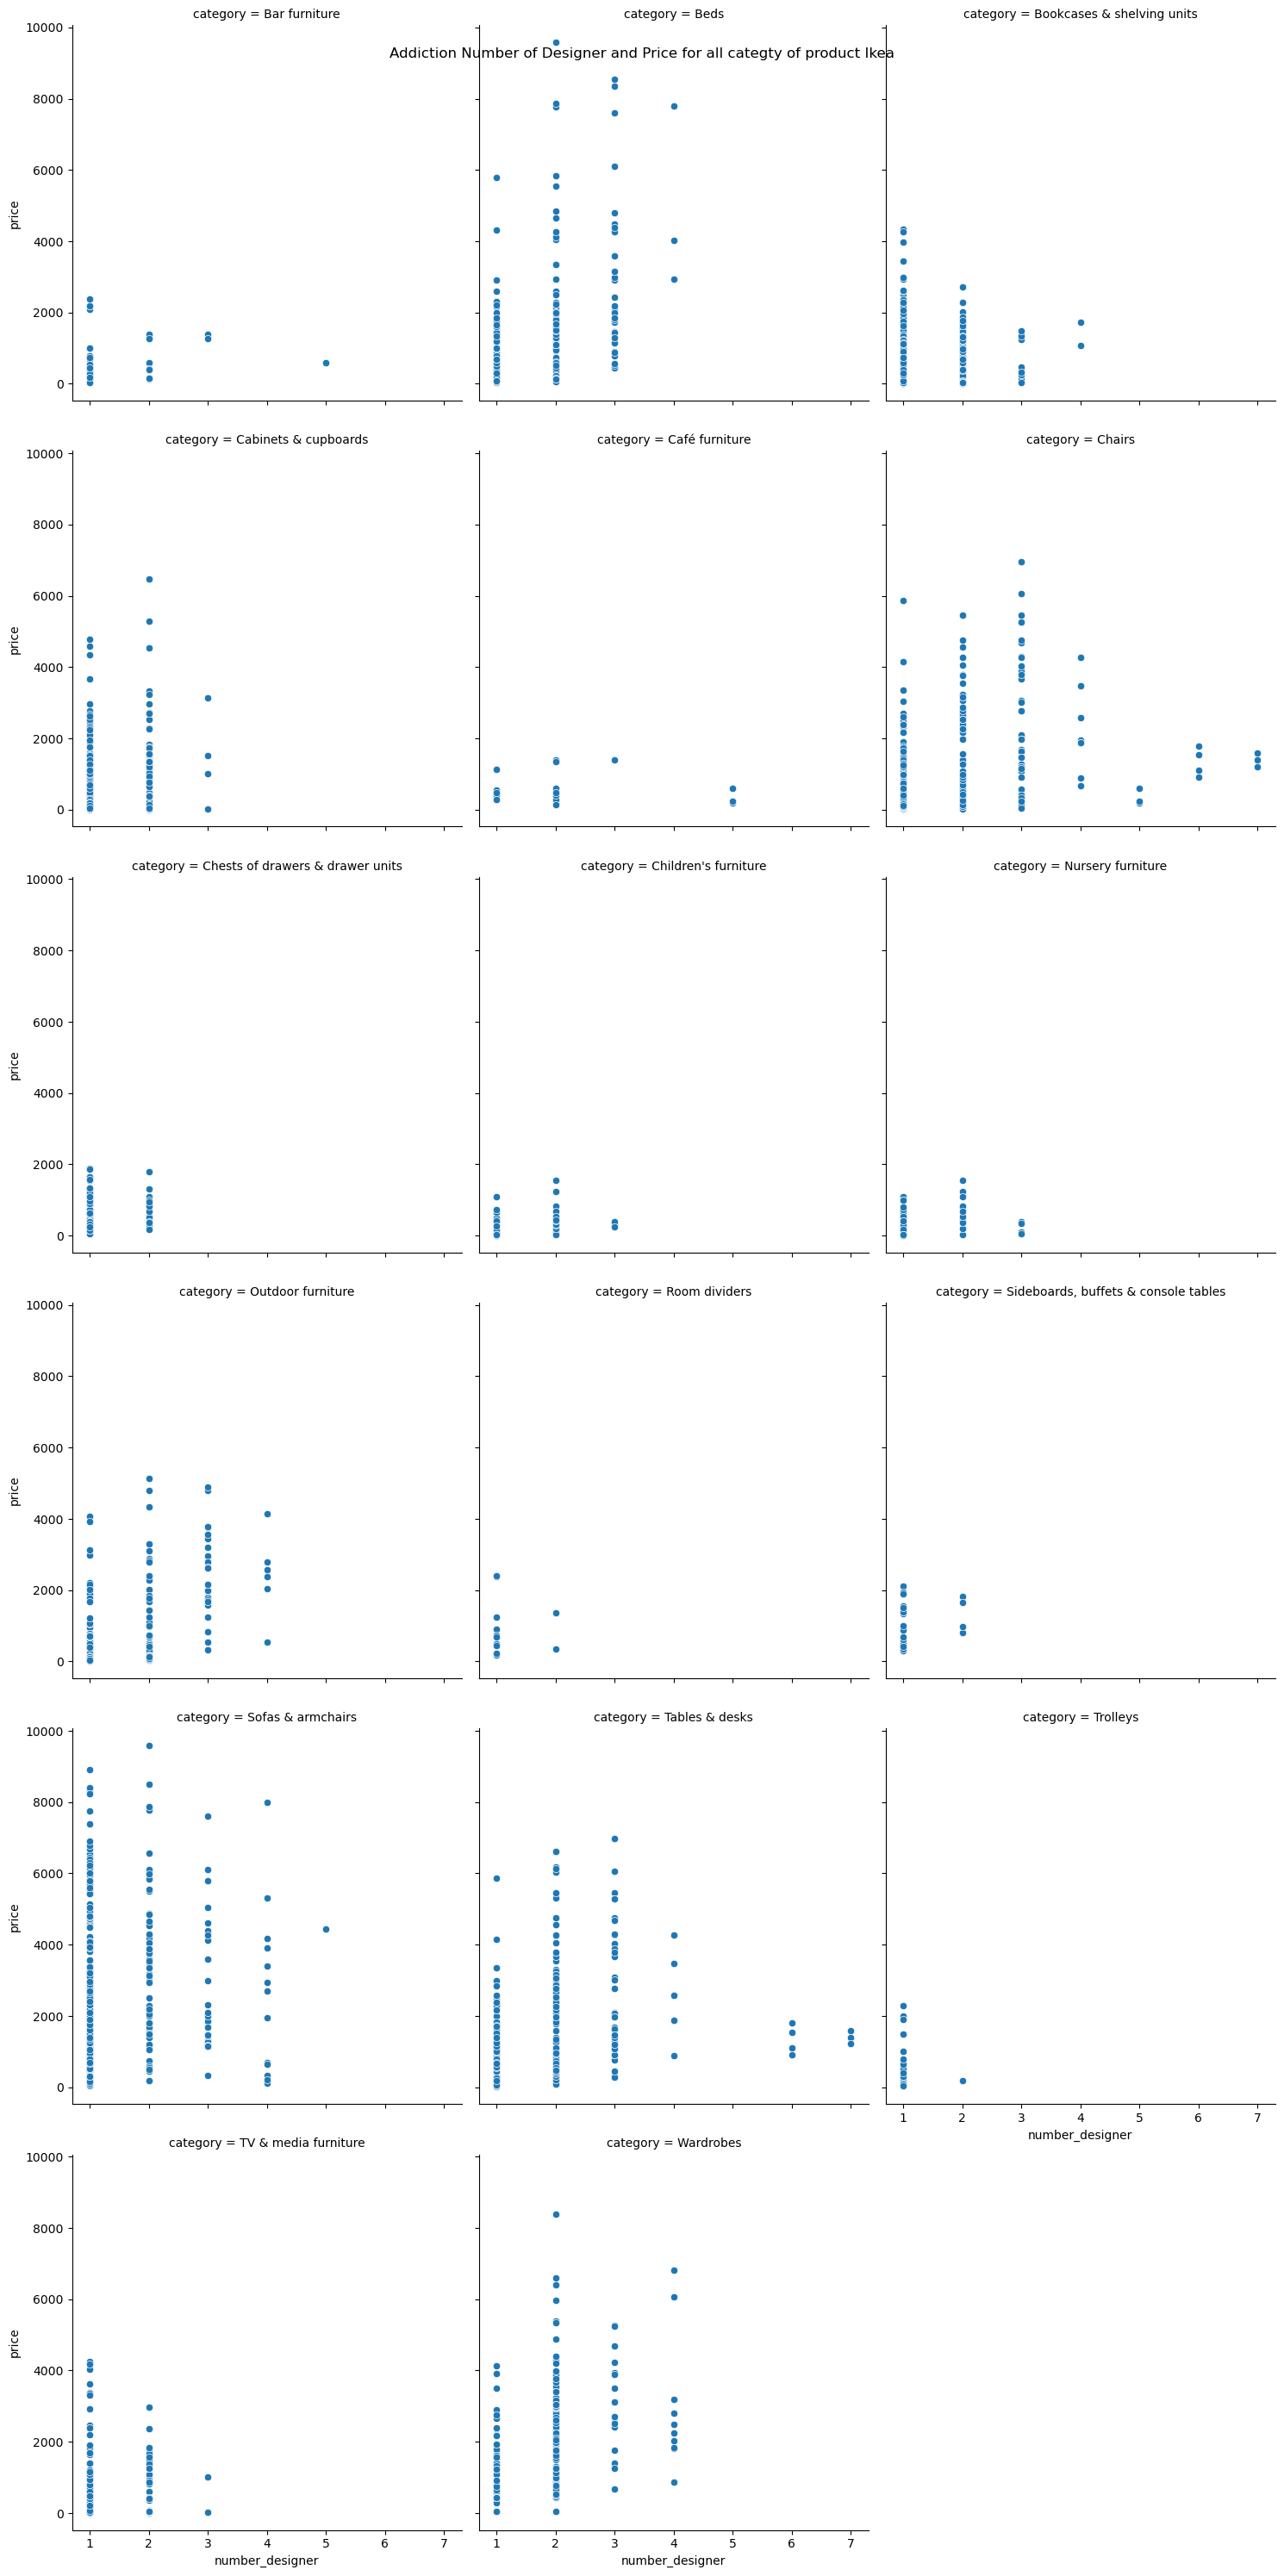

In [242]:
sns.relplot(data=data_dp, x='number_designer', y='price', col='category', col_wrap=3).fig.suptitle(
    'Addiction Number of Designer and Price for all categty of product Ikea', va='top')
plt.show()

Як можна побачити із графічних залежностей, розбиття по категоріях не добавило змісту з точки зору знаходження
кореляцій. 
На мій погляд, дуже мала вирогидність підтвердження альтернативної гіпотези

### 2.2.4. Перший етап перевірки альтернативної гіпотези по критерію Пірсона. Категорія товарів - Wardrobes

In [243]:
data_dp_vardrobes = data_dp.loc[data_ikea['category'] =='Wardrobes']
print('Calculating Pearson`s criteria for addiction Number of Designer and Price for Wardrobes\n')
print(pearsonr(data_dp_vardrobes['number_designer'], data_dp_vardrobes['price']))
print(pearsonr(data_dp_vardrobes['number_designer'], data_dp_vardrobes['price']).confidence_interval())

Calculating Pearson`s criteria for addiction Number of Designer and Price for Wardrobes

PearsonRResult(statistic=0.34831032635127723, pvalue=3.896304148184656e-08)
ConfidenceInterval(low=0.23087921150100013, high=0.4557397787855302)


**Альтернативна гіпотеза за критеріїм Пірсона не підтвердилася.** Критерій Пірсона склав 0,348 (суттєво менше ніж 0,7 за умови нульової гіпотези) із довірчим інтервалом значень від 0,231 до 0,456

### 2.2.5. Другий етап перевірки альтернативної гіпотези по критерію Пірсона. Категорія товарів - Wardrobes ( лінійна форма)

In [244]:
data_dp_vardrobes = data_dp_vardrobes.loc[((data_dp_vardrobes['category'] =='Wardrobes')&((data_dp_vardrobes['corner'] ==0)))]
print('Calculating Pearson`s criteria for addiction Number of Designer and Price for Wardrobes\n')
print(pearsonr(data_dp_vardrobes['number_designer'], data_dp_vardrobes['price']))
print(pearsonr(data_dp_vardrobes['number_designer'], data_dp_vardrobes['price']).confidence_interval())

Calculating Pearson`s criteria for addiction Number of Designer and Price for Wardrobes

PearsonRResult(statistic=0.371191144911755, pvalue=1.0016939453293101e-08)
ConfidenceInterval(low=0.25238874691807495, high=0.4789688824306533)


**Альтернативна гіпотеза за критеріїм Пірсона не підтвердилася.** 
Критерій Пірсона склав 0,371 (суттєво менше ніж 0,7 за умови нульової гіпотези) із довірчим інтервалом значень від 0,252 до 0,479.

### Кореляції між ціною товара і кількістю дизайнерів не існує

### 2.2.6. Виведення точкової діаграми і рівняння лінійної регресії залежності ціни від кількості дизайнерів товара за категорією 'Wardrobes' (лінійна форма)

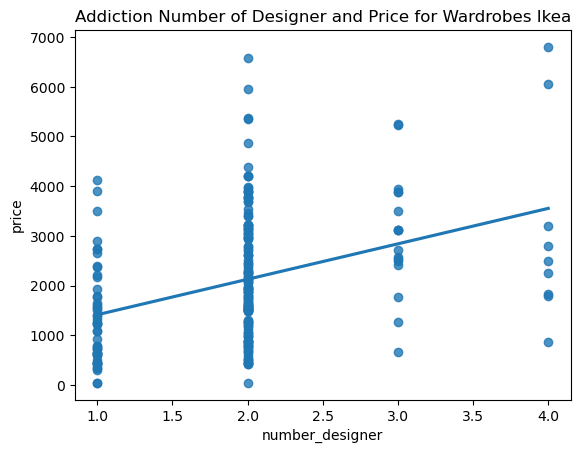

In [245]:
sns.regplot(data=data_dp_vardrobes, x='number_designer', y='price', ci=None, label='linear wardrobes').set (
    title='Addiction Number of Designer and Price for Wardrobes Ikea')
plt.show()

Масив представлених точок на графіку не показує наявність кореліяції між кількості дизайнерів товару та його ціною.
Розташування точок не має якоїсь спільної форми.
Адекватність альтенативної гіпотези не підтвердилося при попередніх розрахунках критерія Пірсона

# 3. Аналіз даних. Створення моделі машинного навчання 

### 3.1. Розробка конвеєра з лінійною регресією залежності вартості шафи від його об'єму для всіх типів  (прямолінійна і кутова)

In [246]:
data_vp = data_ikea[['id_category', 'volume', 'corner', '3d','price']]
data_vp = data_vp.loc[(data_ikea['id_category'] == 17) & (data_vp['3d'] ==3)]

X = data_vp[['volume','corner']].values
y = data_vp['price'].values

scaler = StandardScaler()
clf =  LinearRegression()
steps = [('normalizer', scaler), ('classifier', clf)]

pipe = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
pipe.fit(X_train,y_train)


print('R2 score (train):',pipe.score(X_train, y_train))
print('R2 score (test):',pipe.score(X_test, y_test))

R2 score (train): 0.4783477893514918
R2 score (test): 0.46104407539537606


Як можна бачити, результат щодо середньоквадратичниого відхилення тренувальної та тестової чистин надто малий. Із цього можна зробити висновок щодо потреби в удосконаленні даної моделі.

### 3.2. Створення діаграми з тренувальним та тестувальним масивом даних для моделі п.3.1

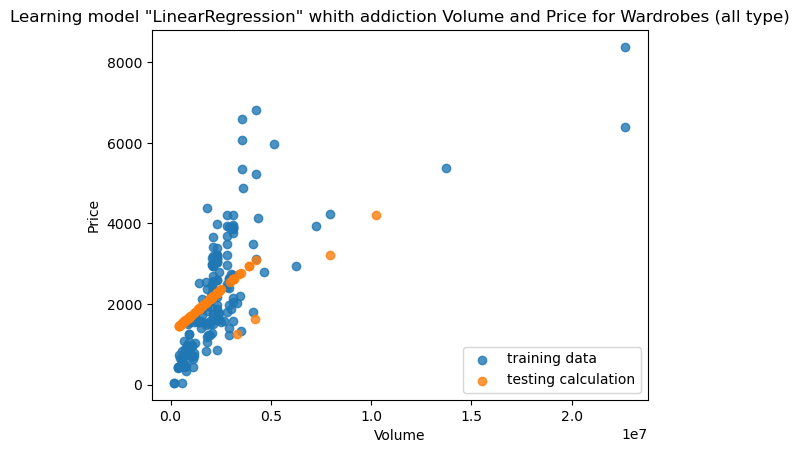

In [247]:
X_train_0=X_train[:,[0]]
X_test_0=X_test[:,[0]]

reg_line=sns.regplot(x=X_train_0, y=y_train, ci=None, fit_reg=False, label='training data')
reg_line=sns.regplot(x=X_test_0, y=pipe.predict(X_test), ci=None, fit_reg=False, label='testing calculation')
reg_line.axes.set_title('Learning model "LinearRegression" whith addiction Volume and Price for Wardrobes (all type)')
reg_line.set_xlabel('Volume')
reg_line.set_ylabel('Price');
plt.legend(loc='lower right')
plt.show()

Із графіка можна побачити, що конвеєр створив дві регресійні залежності - для прямолінійной і для кутової шафи.

### 3.3. Розробка конвеєра з лінійною регресією залежності вартості шафи від його об'єму для прямолінійної шафи

In [248]:
data_vp = data_ikea[['id_category', 'volume', 'corner', '3d','price']]
data_vp = data_vp.loc[(data_ikea['id_category'] == 17) & (data_vp['3d'] ==3) & (data_vp['corner'] == 0)]

X = data_vp[['volume']].values
y = data_vp['price'].values

scaler = StandardScaler()
clf =  LinearRegression()
steps = [('normalizer', scaler), ('classifier', clf)]

pipe_line_wardrobe = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=121)
pipe_line_wardrobe.fit(X_train,y_train)


print('R2 score (train):',pipe_line_wardrobe.score(X_train, y_train))
print('R2 score (test):',pipe_line_wardrobe.score(X_test, y_test))

R2 score (train): 0.5074937066527447
R2 score (test): 0.5853144381179041


Отримані результати показують більш кращі результати, ніж у попередньому варіанті, але всеж таки є малими. Цей варіант конвеєра теж потрібно удосконалювати.

### 3.4. Створення діаграми з тренувальним та тестувальним масивом даних для моделі п.3.3

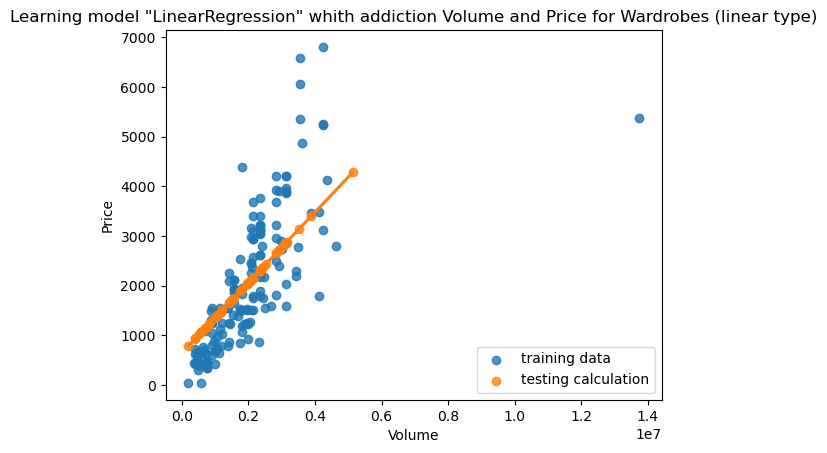

In [249]:
reg_line=sns.regplot(x=X_train, y=y_train, ci=None, fit_reg=False, label='training data')
reg_line=sns.regplot(x=X_test, y=pipe_line_wardrobe.predict(X_test), ci=None, label='testing calculation')
reg_line.axes.set_title('Learning model "LinearRegression" whith addiction Volume and Price for Wardrobes (linear type)')
reg_line.set_xlabel('Volume')
reg_line.set_ylabel('Price');
plt.legend(loc='lower right')
plt.show()

Аналіз представлених даних показує, що одна точка (крайня права із об'ємом приблизно 14000000 см3 та вартістю 5500 од.) не відповідає загальній тенденції відповідності об'єму шафи та його ціни. 

При удосконаленні даної моделі є доцільним прибрати дану точку із розрахунків

### 3.5. Розробка конвеєра з лінійною регресією залежності вартості шафи від його об'єму для кутової шафи

In [250]:
data_vp = data_ikea[['id_category', 'volume', 'corner', '3d', 'price']]
data_vp = data_vp.loc[(data_ikea['id_category'] == 17) & (data_vp['3d'] ==3) & (data_vp['corner'] == 1)]

X = data_vp[['volume']].values
y = data_vp['price'].values

scaler = StandardScaler()
clf =  LinearRegression()
steps = [('normalizer', scaler), ('classifier', clf)]

pipe1 = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
pipe1.fit(X_train,y_train)


print('R2 score (train):',pipe1.score(X_train, y_train))
print('R2 score (test):',pipe1.score(X_test, y_test))

R2 score (train): 0.8159824300018539
R2 score (test): 0.87313101860918


Представлені результати є найкращими серед розроблених моделей. На мій погляд, модель удосконалення не потребує.

### 3.6. Створення діаграми з тренувальним та тестувальним масивом даних для моделі п.3.5

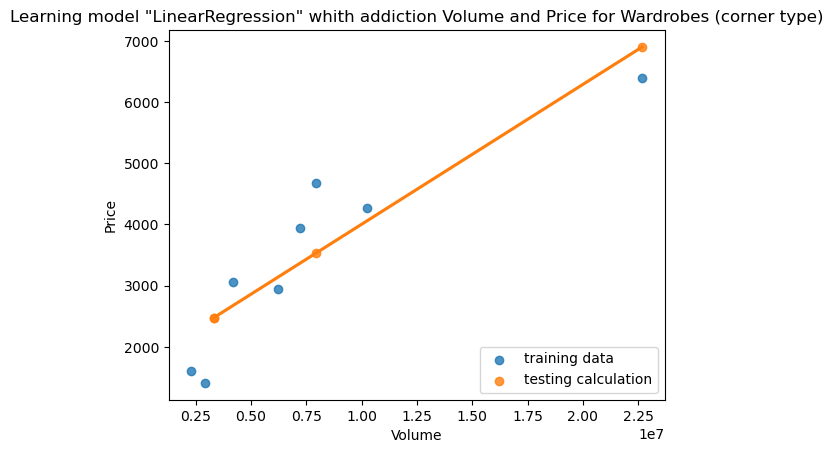

In [251]:
reg_line=sns.regplot(x=X_train, y=y_train, ci=None, fit_reg=False, label='training data')
reg_line=sns.regplot(x=X_test, y=pipe1.predict(X_test), ci=None, label='testing calculation')
reg_line.axes.set_title('Learning model "LinearRegression" whith addiction Volume and Price for Wardrobes (corner type)')
reg_line.set_xlabel('Volume')
reg_line.set_ylabel('Price');
plt.legend(loc='lower right')
plt.show()

Візуальне представлення розрахункової моделі відмінно корелює із масивом даних.

### 3.7. Отримання прогнозних результатів щодо вартості шафи від його розмірів та форми

In [252]:
lengh = 200.0#input('Enter lengh wardrobe (cm):')
depth = 100.0#input('Enter depth wardrobe (cm):')
high = 200.0#input('Enter high wardrobe (cm):')

vol = lengh * depth * high
x_all_0=np.array([[vol,0]])
x_all_1=np.array([[vol,1]])
x0=np.array([[vol]])
x1=np.array([[vol]])

for_price_all_0 = pipe.predict(x_all_0)
for_price_all_1 = pipe.predict(x_all_1)
for_price_0=pipe_line_wardrobe.predict(x0)
for_price_1=pipe1.predict(x1)

print('Predictions price of the product: ')
print('\nLinear wardrobes in summarized model - ', round(for_price_all_0[0],2))
print('Linear wardrobes in local model (preferred) - ', round(for_price_0[0],2))
print('\nCorner wardrobes in summarized model - ', round(for_price_all_1[0],2))
print('Corner wardrobes in local model (preferred) - ', round(for_price_1[0],2))




Predictions price of the product: 

Linear wardrobes in summarized model -  2995.72
Linear wardrobes in local model (preferred) -  3479.8

Corner wardrobes in summarized model -  1541.27
Corner wardrobes in local model (preferred) -  2631.25


# 4. Аналіз даних. Покращення отриманих результатів

## 4.1. Видалення нетипових даних з датасету

### 4.1.1. Графічне представлення нетипової точки в даних з прямолінійною шафою

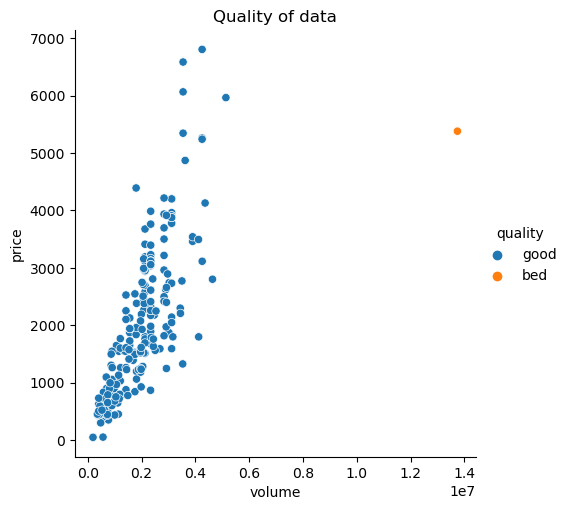

In [253]:
data_vp = data_ikea[['id_category', 'volume', 'corner', '3d','price']]
data_vp = data_vp.loc[(data_vp['id_category'] == 17) & (data_vp['3d'] ==3) & (data_vp['corner'] == 0)]

data_vp.insert(5,'quality', 'good')

max_volume = data_vp['volume'].max()

idx = data_vp[data_vp['volume'] == max_volume].index
data_vp.loc[idx,'quality']='bed'

sns.relplot(data=data_vp, x='volume', y='price', hue='quality').set (title='Quality of data') 

plt.show()

### 4.1.2. Повторне створення датасету для категорії - шафа і видалення нетипової точки

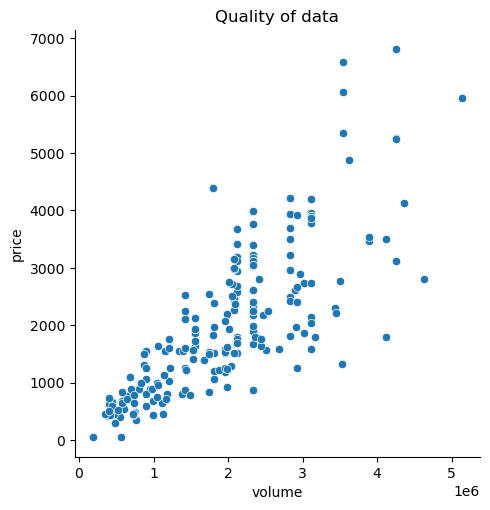

In [254]:
data_vp = data_ikea[['id_category', 'volume', 'corner', '3d','price']]
data_vp = data_vp.loc[(data_vp['id_category'] == 17) & (data_vp['3d'] ==3)]

idx = data_vp[data_vp['volume'] == max_volume].index

data_vp = data_vp.drop (index= idx ) #чистий датафрейм

#візуалізація очищення
data_vp1 = data_vp.loc[(data_vp['id_category'] == 17) & (data_vp['3d'] ==3) & (data_vp['corner'] == 0)]
sns.relplot(data=data_vp1, x='volume', y='price').set (title='Quality of data') 
plt.show()

## 4.2. Перевірка впливу зміни в даних на поведінку раніше отриманих конвеєрів

### 4.2.1. Конвеєр визначення вартості від об'єму для всіх форм шафи (кутова і прямолінійна)

In [255]:
X = data_vp[['volume','corner']].values
y = data_vp['price'].values

scaler = StandardScaler()
clf =  LinearRegression()
steps = [('normalizer', scaler), ('classifier', clf)]

pipe = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)
pipe.fit(X_train,y_train)


print('R2 score (train):',pipe.score(X_train, y_train))
print('R2 score (test):',pipe.score(X_test, y_test))

R2 score (train): 0.41787012102658694
R2 score (test): 0.5797291035780643


Розглядаючи попередній варіант конвеєра для вартості шафи від об'єма (для прямолінійних і кутових форм), можна констатувати що результати практично на змінилися. Видалення однієї точки із масиву даних не вплинуло на кінцевий результат.



### 4.2.2. Конвеєр визначення вартості від об'єму прямолінійної шафи

In [256]:
data_vp0 = data_vp.loc[data_vp['corner'] == 0]

X = data_vp0[['volume']].values
y = data_vp0['price'].values

scaler = StandardScaler()
clf =  LinearRegression()
steps = [('normalizer', scaler), ('classifier', clf)]

pipe_line_wardrobe = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=121)
pipe_line_wardrobe.fit(X_train,y_train)


print('R2 score (train):',pipe_line_wardrobe.score(X_train, y_train))
print('R2 score (test):',pipe_line_wardrobe.score(X_test, y_test))

R2 score (train): 0.6397962488843951
R2 score (test): 0.6221307031473173


Розглядаючи попередній варіант конвеєра для вартості шафи від об'єма (для прямолінійної форм), можна констатувати що результати практично на змінилися. Видалення однієї точки із масиву даних не вплинуло на кінцевий результат.


## 4.3. Покращення моделей машинного навчання із застосуванням кросс-валідації (використання процедури KFold)

### 4.3.1. Визначення оптимальних тренувальних і тестових даних для конвеєра визначення вартості від об'єму для всіх форм шафи (кутова і прямолінійна)

In [257]:
val_in=data_vp[['volume','corner']].values
val_out=data_vp[['price']].values

# инициализация KFold с 20-тью фолдами
kf = KFold(n_splits=20, random_state=111, shuffle=True)

scaler = StandardScaler()
clf =  LinearRegression()
steps = [('normalizer', scaler), ('classifier', clf)]

pipe_cv = Pipeline(steps) #cv - cross-validation

for i, (train_index, test_index) in enumerate(kf.split(val_in)):
    print(f'Data_split {i}:')
    X_train=val_in[train_index]
    y_train=val_out[train_index]
    X_test=val_in[test_index]
    y_test=val_out[test_index]
    pipe_cv.fit(X_train,y_train)
    print('R2 score (train):',pipe_cv.score(X_train, y_train))
    print('R2 score (test):',pipe_cv.score(X_test, y_test))

Data_split 0:
R2 score (train): 0.4590917694807103
R2 score (test): 0.5420516649063225
Data_split 1:
R2 score (train): 0.49114039118227293
R2 score (test): 0.2969768126382777
Data_split 2:
R2 score (train): 0.48644276339792347
R2 score (test): 0.5067429293195487
Data_split 3:
R2 score (train): 0.4852605840135831
R2 score (test): -0.228375686442017
Data_split 4:
R2 score (train): 0.48258694604540664
R2 score (test): 0.5158102593316038
Data_split 5:
R2 score (train): 0.49075036355931645
R2 score (test): 0.3787658937225925
Data_split 6:
R2 score (train): 0.4850878292086782
R2 score (test): 0.5201116432099347
Data_split 7:
R2 score (train): 0.4776213330392941
R2 score (test): 0.7352568983387004
Data_split 8:
R2 score (train): 0.5137635624422231
R2 score (test): 0.20854545770747424
Data_split 9:
R2 score (train): 0.4832742045417596
R2 score (test): 0.5467455695491915
Data_split 10:
R2 score (train): 0.4805160151983082
R2 score (test): 0.5039381311591646
Data_split 11:
R2 score (train): 0.48

Найкращий результат, отриманий при розрахунках знаходиться у сьомому спліті з наступними параметрами:

Data_split 7:

R2 score (train): 0.4776213330392941

R2 score (test): 0.7352568983387004

Треновочний показник залишився майже таким як і в попередньому варіанті (п.3.1 - було 0,47), проте тестовий показник суттєво збільшився (було 0,46)

### 4.3.2. Навчання моделі із найкращим сплітом за п.4.3.1

In [258]:
for i, (train_index, test_index) in enumerate(kf.split(val_in)):
    X_train=val_in[train_index]
    y_train=val_out[train_index]
    X_test=val_in[test_index]
    y_test=val_out[test_index]
    pipe_cv.fit(X_train,y_train)
    if i==7:
        break

### 4.3.3. Порявняння прогнозної вартості шафи на моделях до кросс-валідації (п.3.1) та після неї (п.4.3.2)

In [259]:
lengh = 200.0#input('Enter lengh wardrobe (cm):')
depth = 100.0#input('Enter depth wardrobe (cm):')
high = 200.0#input('Enter high wardrobe (cm):')

vol = lengh * depth * high
x_all_0=np.array([[vol,0]])
x_all_1=np.array([[vol,1]])

pred_price = pipe.predict(x_all_0)

print('\nPredictions price of the product: ')
pred_price = pipe.predict(x_all_0)
print('\nLinear wardrobes in model until cross-validation - ', pred_price)
pred_price = pipe_cv.predict(x_all_0)
print('Linear wardrobes in model after cross-validation - ', pred_price)
pred_price = pipe.predict(x_all_1)
print('\nCorner wardrobes in model until cross-validation - ', pred_price)
pred_price = pipe_cv.predict(x_all_1)
print('Corner wardrobes in model after cross-validation - ', pred_price)


Predictions price of the product: 

Linear wardrobes in model until cross-validation -  [3017.7311576]
Linear wardrobes in model after cross-validation -  [[3045.90541178]]

Corner wardrobes in model until cross-validation -  [1937.79877647]
Corner wardrobes in model after cross-validation -  [[1636.99988379]]


### 4.3.4. Визначення оптимальних тренувальних і тестових даних для конвеєра визначення вартості від об'єму для прямолінійної форм шафи

In [260]:
val_in=data_vp0[['volume']].values
val_out=data_vp0[['price']].values

# инициализация KFold с 20-тью фолдами
kf = KFold(n_splits=20, random_state=111, shuffle=True)

scaler = StandardScaler()
clf =  LinearRegression()
steps = [('normalizer', scaler), ('classifier', clf)]

pipe_cv = Pipeline(steps) #cv - cross-validation

for i, (train_index, test_index) in enumerate(kf.split(val_in)):
    print(f'Data_split {i}:')
    X_train=val_in[train_index]
    y_train=val_out[train_index]
    X_test=val_in[test_index]
    y_test=val_out[test_index]
    pipe_cv.fit(X_train,y_train)
    print('R2 score (train):',pipe_cv.score(X_train, y_train))
    print('R2 score (test):',pipe_cv.score(X_test, y_test))

Data_split 0:
R2 score (train): 0.6411858579666232
R2 score (test): 0.35171167900260536
Data_split 1:
R2 score (train): 0.6466607174536008
R2 score (test): 0.49787532301918414
Data_split 2:
R2 score (train): 0.6416699068871315
R2 score (test): 0.6101320780253534
Data_split 3:
R2 score (train): 0.6384384932038456
R2 score (test): 0.6487901527682378
Data_split 4:
R2 score (train): 0.6401397195837122
R2 score (test): 0.4681861814804119
Data_split 5:
R2 score (train): 0.6496240567965348
R2 score (test): 0.2134745656002377
Data_split 6:
R2 score (train): 0.6632751478707856
R2 score (test): -0.27309355422374404
Data_split 7:
R2 score (train): 0.6357713229391133
R2 score (test): 0.744405926388971
Data_split 8:
R2 score (train): 0.6379275439814152
R2 score (test): 0.589543333695967
Data_split 9:
R2 score (train): 0.6439467298434807
R2 score (test): 0.49939291121432794
Data_split 10:
R2 score (train): 0.6212959292864536
R2 score (test): 0.8506607590903486
Data_split 11:
R2 score (train): 0.6448

Найкращий результат, отриманий при розрахунках знаходиться у першому спліті з наступними параметрами:

Data_split 1:

R2 score (train): 0.5139200780413039

R2 score (test): 0.7366961516766277

Треновочний показник незначно збільшився у порівнянні з попередним варіантом (п.3.3 - було 0,51), а тестовий показник суттєво збільшився (було 0,58)

### 4.3.5. Навчання моделі із найкращим сплітом за п.4.3.4

In [261]:
for i, (train_index, test_index) in enumerate(kf.split(val_in)):
    X_train=val_in[train_index]
    y_train=val_out[train_index]
    X_test=val_in[test_index]
    y_test=val_out[test_index]
    pipe_cv.fit(X_train,y_train)
    if i==1:
        break

### 4.3.3. Порявняння прогнозної вартості шафи на моделях до кросс-валідації (п.3.3) та після неї (п.4.3.5)

In [262]:
lengh = 200.0#input('Enter lengh wardrobe (cm):')
depth = 100.0#input('Enter depth wardrobe (cm):')
high = 200.0#input('Enter high wardrobe (cm):')

vol = lengh * depth * high
x_all_0=np.array([[vol]])

pred_price = pipe_line_wardrobe.predict(x_all_0)

print('\nPredictions price of the product: ')
pred_price = pipe_line_wardrobe.predict(x_all_0)
print('\nLinear wardrobes in model until cross-validation - ', pred_price)
pred_price = pipe_cv.predict(x_all_0)
print('Linear wardrobes in model after cross-validation - ', pred_price)


Predictions price of the product: 

Linear wardrobes in model until cross-validation -  [4246.5463502]
Linear wardrobes in model after cross-validation -  [[4139.79654462]]
